# What is a Generative Adversarial Networks (GAN)

GAN is a class of machine learning model that uses two different neural network. 
<br>
-One Generator train to generate new samples.
<br>
-One Discriminator train to classify a sample as Real (image from dataset) or Fake (Image generated with the generator).
<br>
These two models are trained together until the discriminator is fooled about half the time, which mean the new sample creatted by the generator can be classify as "Real" 

![Inlet Spike](assets/gan2.png)

## How GAN works
First, the Generator takes as input a random vector of fixed size (latent variable) and output an images, it learn by tricking the Discriminator.
<br>
Then, the Discrimitor learn to distinguish between Real and Fake images. To do so, it learn pattern and features from the images and once it is trained, it tries to identify these features in the image given as input. 

## GAN Process

**STEP 1**: Generate latent variable (noise vector).
<br>
**STEP 2**: Give the vector to the Generator to create fake images.
<br>
**STEP 3**: Sample Real and Fake images
<br>
**STEP 4**: Train Discriminator with the mixed set
<br>
**STEP 5**: Generate fake images but lebelled them as Real
<br>
**STEP 6**: Train GAN using noise vectore labeled as real images

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
import PIL
import matplotlib.pyplot as plt
from IPython import display
import os
import glob
from sklearn.utils import shuffle


## GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset 

The GAN will be trained by using Stanfords Dogs datasat which is composed of about 20000 images and 120 breeds of dogs.

In [14]:
def load_images(main_folder="./Images", target_size=(32, 32)):
    images = []
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        image_paths = glob.glob(subfolder_path + '/*.[jJ][pP][gG]')
        for image_path in image_paths:
            image = PIL.Image.open(image_path)
            image = image.resize(target_size)
            image = np.array(image)
            if image.shape != (32, 32, 3):
               print("ERRRRROOOOOR", image.shape, " ADN  ", image_path)
            images.append(image)
    
    np_images = np.array(images)
    return np_images

def load_real_sample(images):
    X = images.astype('float32')
    X = (X - 127.5) / 127.5

    # Get pixel between -1 and 1
    return X

<function matplotlib.pyplot.show(close=None, block=None)>

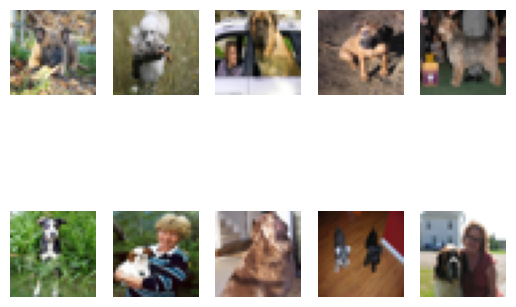

In [15]:
images = load_images("./Images")
images = shuffle(images, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(20580).batch(64)

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(0, len(images))
    plt.axis('off')
    plt.imshow(images[random_index])
plt.show


## Generator Model

In [5]:
def create_model_generator():
    model = Sequential()

    model.add(Dense(8 * 8 * 128, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    assert model.output_shape == (None, 8, 8, 128)

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (8, 8), padding='same'))
    assert model.output_shape == (None, 32, 32, 3)

    return model


## Discriminator Model

In [6]:
def create_model_discriminator():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [7]:
def create_model_gan(generator, discriminator):
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model


In [8]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim) 
    return x_input

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [11]:
def train(generator, discriminator, gan, dataset, n_epochs=250, n_batch=128, ):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(generator, 100, half_batch)

            d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)
            d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(100, n_batch)
            y_gan = np.ones((n_batch, 1))

            g_loss = gan.train_on_batch(X_gan, y_gan)

            print('Epoch: %d, Batch: %d, d_loss_real: %.3f, d_loss_fake: %.3f, g_loss: %.3f' % (i+1, j+1, d_loss_real, d_loss_fake, g_loss))

    generator.save('generator.h5')


In [16]:
discriminator = create_model_discriminator()
generator = create_model_generator()
gan = create_model_gan(generator, discriminator)

dataset = load_real_sample(images)
train(generator, discriminator, gan, dataset)

2/2 [==============================] - 2s 7ms/step
Epoch: 1, Batch: 1, d_loss_real: 0.748, d_loss_fake: 0.695, g_loss: 0.692
2/2 [==============================] - 0s 9ms/step
Epoch: 1, Batch: 2, d_loss_real: 0.658, d_loss_fake: 0.702, g_loss: 0.686
2/2 [==============================] - 0s 9ms/step
Epoch: 1, Batch: 3, d_loss_real: 0.605, d_loss_fake: 0.711, g_loss: 0.677
2/2 [==============================] - 0s 9ms/step
Epoch: 1, Batch: 4, d_loss_real: 0.552, d_loss_fake: 0.724, g_loss: 0.669
2/2 [==============================] - 0s 10ms/step
Epoch: 1, Batch: 5, d_loss_real: 0.502, d_loss_fake: 0.736, g_loss: 0.663
2/2 [==============================] - 0s 13ms/step
Epoch: 1, Batch: 6, d_loss_real: 0.471, d_loss_fake: 0.748, g_loss: 0.662
2/2 [==============================] - 0s 8ms/step
Epoch: 1, Batch: 7, d_loss_real: 0.400, d_loss_fake: 0.751, g_loss: 0.675
2/2 [==============================] - 0s 9ms/step
Epoch: 1, Batch: 8, d_loss_real: 0.350, d_loss_fake: 0.752, g_loss: 0.68

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('generator.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck



  0%|          | 0/644 [00:00<?, ?it/s]

c:\Users\Hugo\anaconda3\envs\pygpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


[1/100][322/644] Loss_D: 3.5672 Loss_G: 0.0589
[1/100][644/644] Loss_D: 6.3587 Loss_G: 0.0024


  0%|          | 0/644 [00:00<?, ?it/s]

[2/100][322/644] Loss_D: 7.7140 Loss_G: 0.0005
[2/100][644/644] Loss_D: 9.7985 Loss_G: 0.0001


  0%|          | 0/644 [00:00<?, ?it/s]

KeyboardInterrupt: 